In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set_style('darkgrid')

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


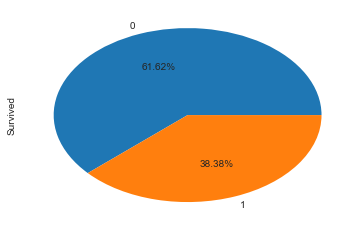

In [5]:
train_data['Survived'].value_counts().plot(kind='pie', autopct='%1.2f%%');

## 补全数据
将`Embarked`这一栏缺失的值用最多的一个值来代替

In [6]:
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values

将`Cabin`这一栏缺失的值用`U0`来代替，代表Unknown

In [7]:
train_data.Cabin = train_data.Cabin.fillna('U0')

将Age这一栏缺失的值利用回归算法得出的值替代，这里用随机森林做回归算法的模型

In [8]:
from sklearn.ensemble import RandomForestRegressor

age_df = train_data[['Age', 'Survived', 'Pclass', 'SibSp', 'Parch', 'Fare']]
age_notnull = age_df.loc[(train_data['Age'].notnull())]
age_isnull = age_df.loc[(train_data['Age'].isnull())]
X = age_notnull.values[:, 1:]
y = age_notnull.values[:, 0]
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X, y)
predict_ages = RFR.predict(age_isnull.values[:, 1:])
train_data.loc[train_data.Age.isnull(), ['Age']] = predict_ages

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 分析数据

### Sex vs. Survived

In [10]:
train_data.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

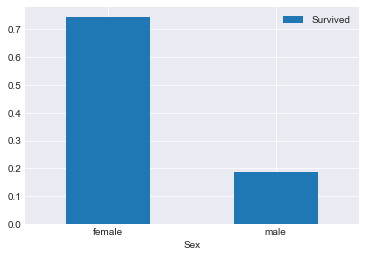

In [11]:
# 画出每个性别具体存活人数
# sns.countplot('Sex', data=train_data[train_data.Survived == 1]);
# sns.factorplot(x='Sex', data=train_data, col='Survived', kind='count');

# 求每个性别的存活率
# 这个地方用mean来算存活率真是非常精妙的一步，写法既简洁又易懂
train_data[['Sex', 'Survived']].groupby('Sex').mean().plot(kind='bar', rot=0);

### Pclass vs. Survived

In [12]:
train_data.groupby(['Pclass', 'Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

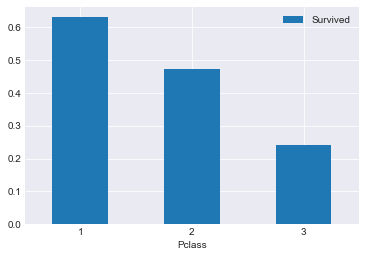

In [13]:
# sns.countplot('Pclass', data=train_data[train_data.Survived == 1]);

train_data[['Pclass', 'Survived']].groupby('Pclass').mean().plot(kind='bar', rot=0);

### Age vs. Survived

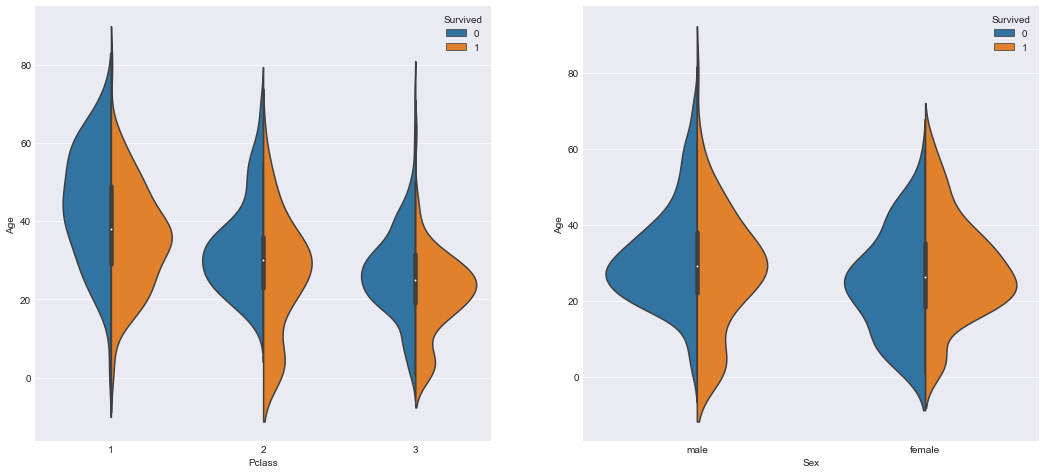

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot("Pclass", "Age", hue="Survived", data=train_data, split=True, ax=ax[0])
sns.violinplot("Sex", "Age", hue="Survived", data=train_data, split=True, ax=ax[1])
plt.show();

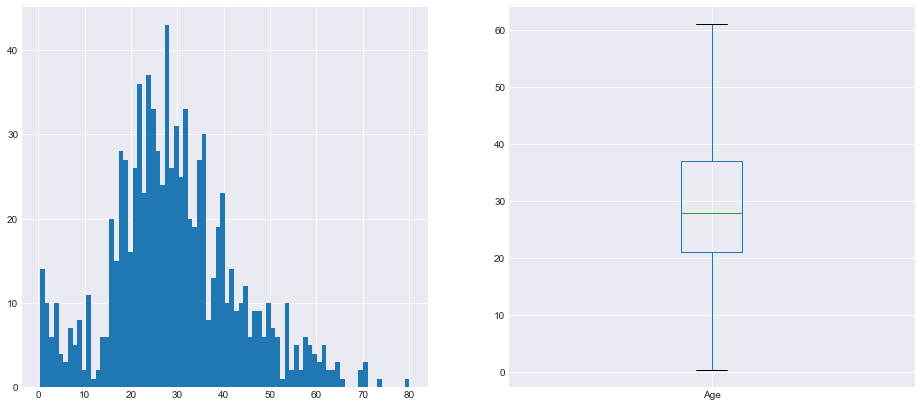

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
train_data['Age'].hist(bins=80, ax=ax[0])
train_data['Age'].plot(kind='box', ax=ax[1], showfliers=False)
plt.show();

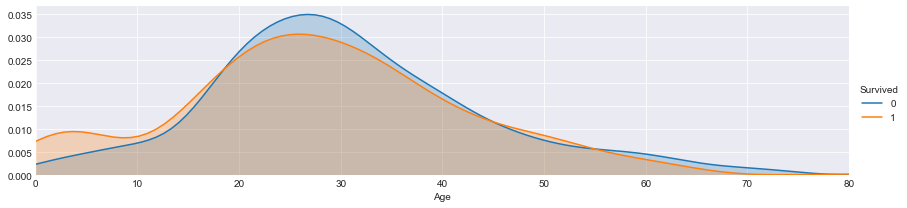

In [16]:
facet = sns.FacetGrid(train_data, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train_data['Age'].max()))
facet.add_legend()

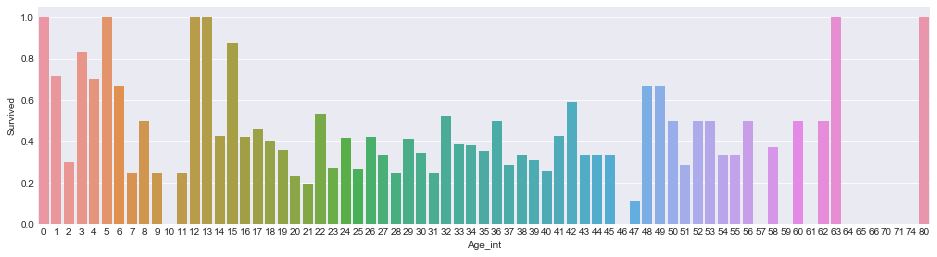

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
train_data['Age_int'] = train_data['Age'].astype(int)
average_age = train_data[['Age_int', 'Survived']].groupby('Age_int', as_index=False).mean()
sns.barplot('Age_int', 'Survived', data=average_age);

### Name vs. Survived

In [18]:
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_data['Title'], train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


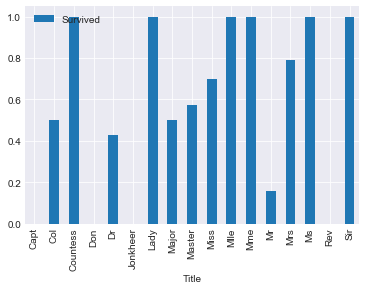

In [19]:
train_data[['Title', 'Survived']].groupby('Title').mean().plot(kind='bar');

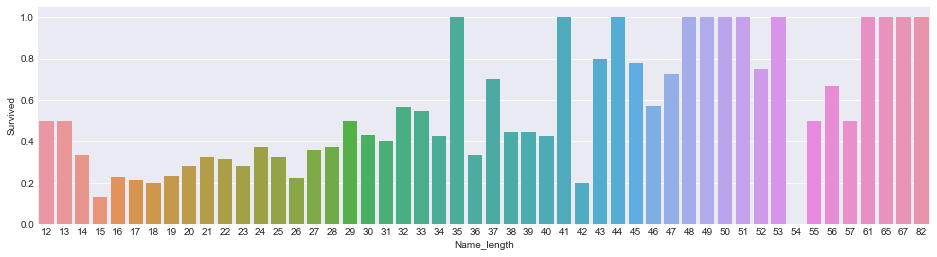

In [20]:
train_data['Name_length'] = train_data['Name'].apply(len)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
name_length = train_data[['Name_length', 'Survived']].groupby('Name_length', as_index=False).mean()
sns.barplot('Name_length', 'Survived', data=name_length);

### SibSp vs. Survived

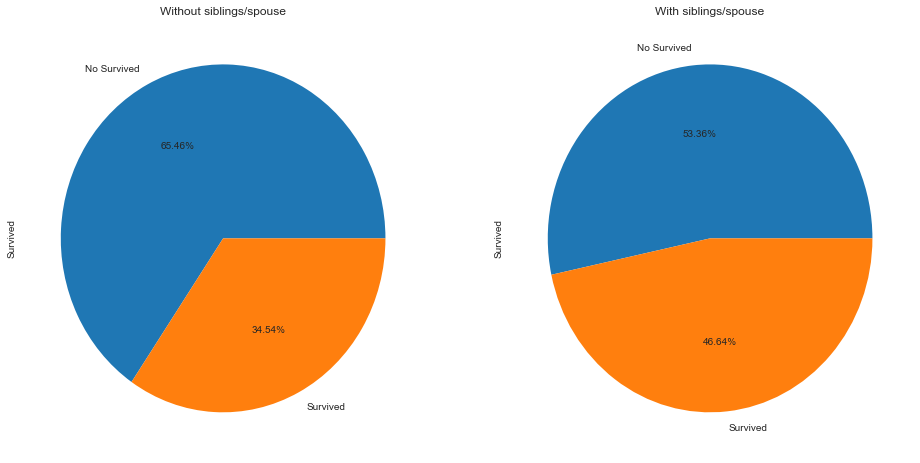

In [21]:
no_sib = train_data[train_data['SibSp'] == 0]['Survived'].value_counts()
sib = train_data[train_data['SibSp'] != 0]['Survived'].value_counts()
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
no_sib.plot(kind='pie', title='Without siblings/spouse', labels=['No Survived', 'Survived'], autopct='%1.2f%%',  ax=ax[0])
sib.plot(kind='pie', title='With siblings/spouse', labels=['No Survived', 'Survived'], autopct='%1.2f%%', ax=ax[1])
plt.show();

### Parch vs. Survived

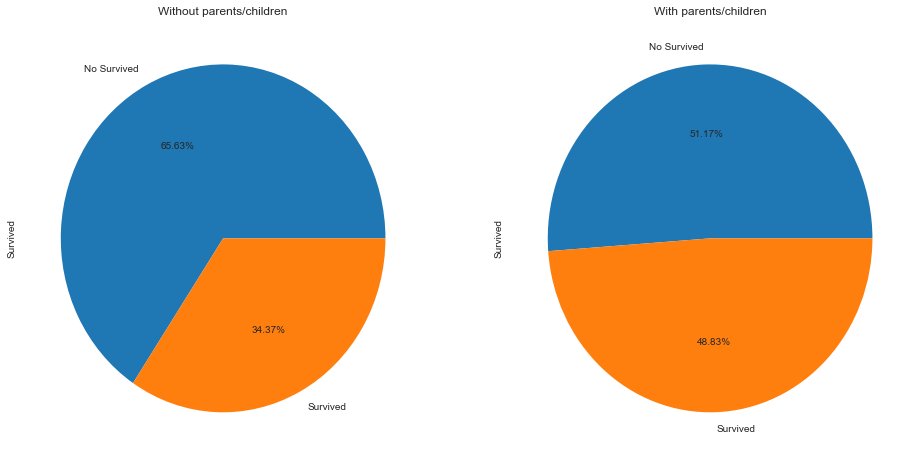

In [22]:
no_par = train_data[train_data['Parch'] == 0]['Survived'].value_counts()
par = train_data[train_data['Parch'] != 0]['Survived'].value_counts()
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
no_par.plot(kind='pie', title='Without parents/children', labels=['No Survived', 'Survived'], autopct='%1.2f%%',  ax=ax[0])
par.plot(kind='pie', title='With parents/children', labels=['No Survived', 'Survived'], autopct='%1.2f%%', ax=ax[1])
plt.show();

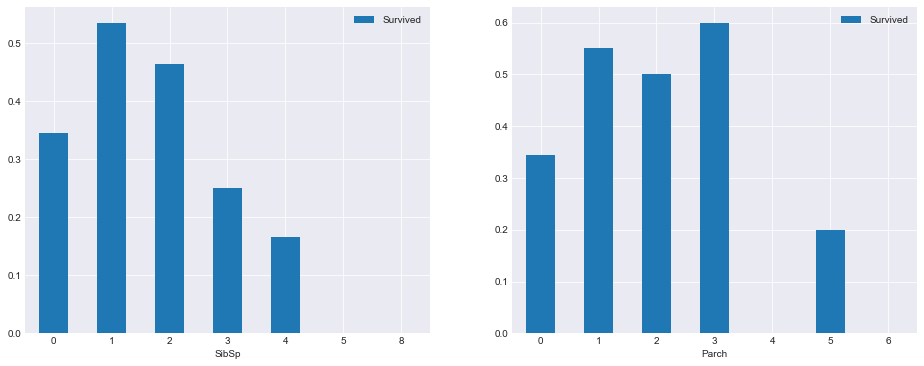

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
train_data[['SibSp', 'Survived']].groupby('SibSp').mean().plot(kind='bar', ax=ax[0], rot=0)
train_data[['Parch', 'Survived']].groupby('Parch').mean().plot(kind='bar', ax=ax[1], rot=0)
plt.show();

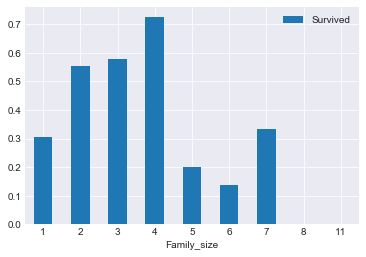

In [24]:
train_data['Family_size'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data[['Family_size', 'Survived']].groupby('Family_size').mean().plot(kind='bar', rot=0);

### Fare vs. Survived

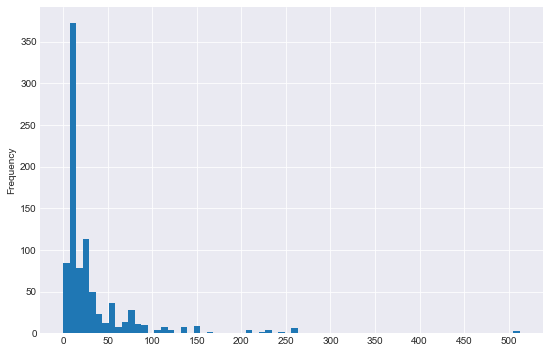

In [31]:
train_data['Fare'].plot(kind='hist', bins=70, xticks=range(0, 550, 50));

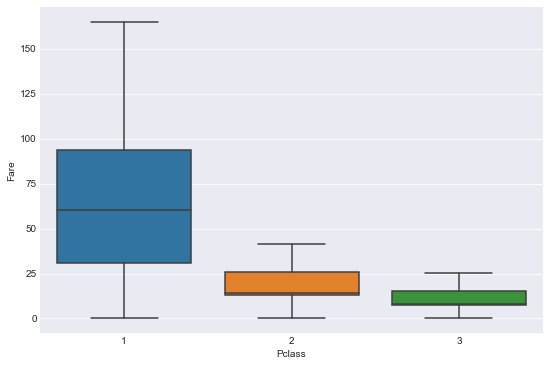

In [38]:
sns.boxplot(y='Fare', x='Pclass', data=train_data, showfliers=False);

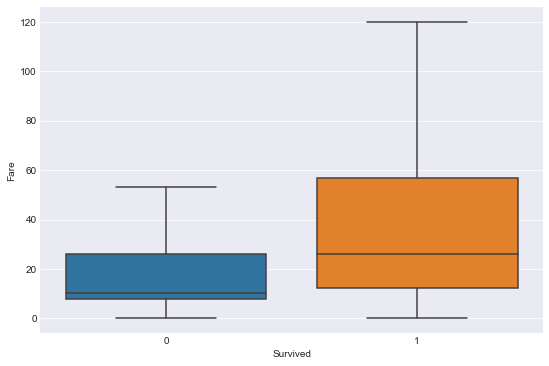

In [37]:
sns.boxplot(x='Survived', y='Fare', data=train_data, showfliers=False);

### Cabin vs. Survived

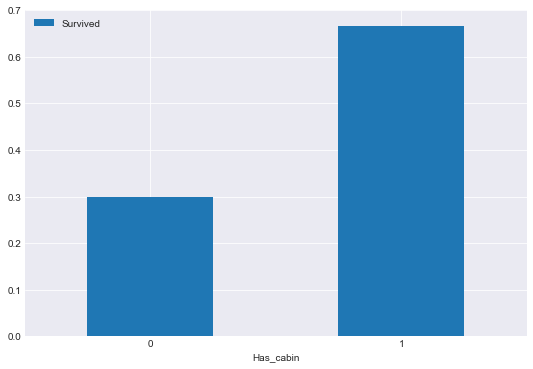

In [47]:
train_data['Has_cabin'] = train_data['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)
train_data[['Has_cabin', 'Survived']].groupby('Has_cabin').mean().plot(kind='bar', rot=0);

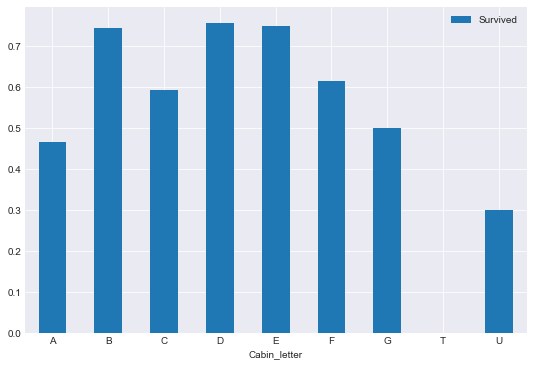

In [57]:
import re
cabin_letter = train_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
train_data['Cabin_letter'] = cabin_letter
train_data[['Cabin_letter', 'Survived']].groupby('Cabin_letter').mean().plot(kind='bar', rot=0);

### Embarked vs. Survived

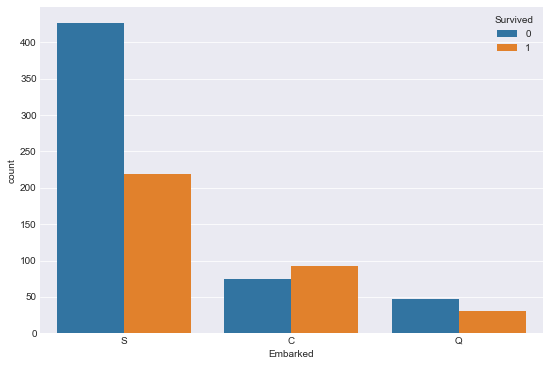

In [58]:
sns.countplot('Embarked', hue='Survived', data=train_data);

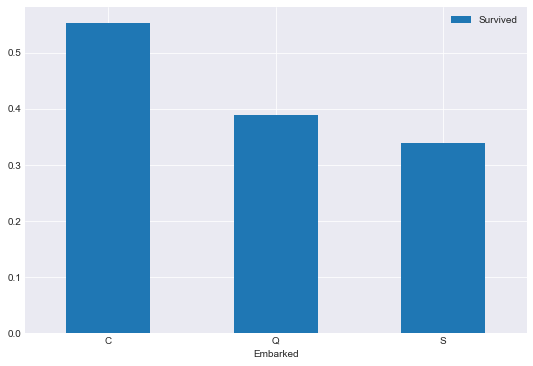

In [59]:
train_data[['Embarked', 'Survived']].groupby('Embarked').mean().plot(kind='bar', rot=0);

## Data Preprocessing

### Embarked into dummies

In [68]:
embark_dummy = pd.get_dummies(train_data['Embarked'])
# train_data = train_data.join(embark_dummy)

In [69]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_int', 'Title',
       'Name_length', 'Family_size', 'Has_cabin', 'Cabin_letter', 'C', 'Q',
       'S'],
      dtype='object')

### Scaling Age

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data['Age_scaled'] = scaler.fit_transform(train_data['Age'].reshape(-1, 1))

In [75]:
train_data['Age_scaled'].head()

0   -0.558023
1    0.607303
2   -0.266692
3    0.388804
4    0.388804
Name: Age_scaled, dtype: float64